# Assignment 2

***

## Question 1: Neural Codes & Nearest Neighbor retrieval (7.5pt)
The Caltech101 dataset consists of images of 101 different objects. In this question you will develop an image retrieval system using image representations (neural codes) learned with a deep convolutional neural network and a given distance metric.

In the tasks below you will need to implement the following steps:

* Retrieval for $n$ selected (distinct) query images from the dataset
    * For each query image, obtain the 5 most similar images (excluding the query image itself!)
* Evaluation of the quality of the retrieval 
    * The Caltech101 images are annotated with their object class. Use these annotations to evaluate the accuracy of the retrieval task.
    * For each query image, count the number of images whose class corresponds to the one from the query. The score of the retrieval for that image then ranges between:
        * **5** *all* retrieved images' classes agree with the query image class
        * **0** *none* of the images' classes agree with the query image class
    * Compute the average of all $n$ queries

***

### Task 1.1:  Neural codes image retrieval
**a)** Implement the retrieval task and evaluate the results for $n=200$ images. Use the provided VGG16 network pre-trained on ImageNet to compute "neural codes" and L2-distance. Specifically use the codes produces by the following layers of the model: 
1. the "fc1"-layer
2. the "fc2"-layer

Provide the retrieval evaluation scores for both tasks.

In [1]:
# you'll need these imports:
from keras.preprocessing import image
from sklearn.neighbors import NearestNeighbors
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

/Users/daphne/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# NOTE: you will first need to apply some changes to "Practical-3.3.0_preprocess-caltech101.ipynb" and run it
#       to obtain a pickle file with "fc1"-features. You don't need to show these changes here.


# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 8677  # the dataset has 8677 images
indices = np.random.choice(range(n_examples), size=n, replace=False)

def show_img(filepath):
    img = image.load_img(filepath, target_size=(224,224))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
# iterate over two data representations (make sure these two files exist in the "data" subfolder first)
for datapath in ("caltech101_VGG16_fc1.p", "caltech101_VGG16_fc2.p"):
    # load the dataset
    with open(os.path.join("data", datapath), "rb") as f:
        X_fc, y, X_paths, classes = pickle.load(f)


    # === SOLUTION: ===    
    neigh = NearestNeighbors(n_neighbors=6, p=2)
    neigh.fit(X_fc)
    X = X_fc[indices]
    nn = neigh.kneighbors(X)
    average = 0
    # Iterate over the instances.
    for i, distances, nn_indices in zip(indices, nn[0], nn[1]):
        # Find the original and its properties
        original_class = classes[y[i]]
        # Don't start at zero, because the first neighbor is the original.
        score = -1
        for dist, j in zip(distances, nn_indices):
            if(classes[y[j]] == original_class):
                score += 1
        average = average + score
    average = average/n
    print("(Datapath: {}, average score: {})".format(datapath, average))


(Datapath: caltech101_VGG16_fc1.p, average score: 3.45)
(Datapath: caltech101_VGG16_fc2.p, average score: 3.74)


***

**b)** Which representation ("neural code") provided better features for the given retrieval task? 
Justify your answer and discuss possible reasons for the observed results. Relate your answer to the conclusions in the paper "Neural Codes for Image Retrieval".

**Answer:**

As reflected in the scores calculated above, it seems that the fc2 layer representations perform a bit better on the retrieval tasks. The scores depend on the images that are chosen, but overall, fc2 consistently scores higher.

When we relate this code to the Babenko et al. paper, it looks like fc1 and fc2 from VCC16 would correspond to their L6 and L7, the final two fully connected layers before the output. The results of Babenko et al. show the best performance at L6, two levels below the outputs. We, on the other hand, found the best performance in fc2, on layer below the outputs, with worse performance for fc1 which is two layers below the outputs.

Babenko et al. speculate that this is because the top layers are tuned too much for the classification task, whereas they perform a retrieval task. Our experiment on the other hand, does involve a classification task. The network was not trained on the dataset it classified in both cases, so there should be no difference in that sense. The Keras VGG16 implementation was trained on Imagenet, but evaluated on Caltech101. From this we conclude that the difference in most effective layer must be due to the different tasks performed in Babenko et al. versus this assignment.

***

### Task 1.2: Detailed evaluation
**a)** The retrieval scores can vary from one query image to another. Some images are quite representative and for them retrieval works well, some are not so much.
For the same retrieval task given above using "fc2"-features, find (if possible) six query images such that they range from excellent to poor retrieval performance. More specifically find example query images that result in query scores of exactly 0, 1, 2, 3, 4, and 5.

Visualise the six (or less) resulting query images.

In [3]:
# you'll need these extra imports:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# load the dataset
datapath = "caltech101_VGG16_fc2.p"
with open(os.path.join("data", datapath), "rb") as f:
    X_fc, y, X_paths, classes = pickle.load(f)

# you can use this simple function to visualise an image, given a filepath
def show_img(filepath):
    img = image.load_img(filepath, target_size=(224,224))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
# example usage given some index < 8677:
#index = 254
#show_img(X_paths[index])


# === SOLUTION: ===
neigh = NearestNeighbors(n_neighbors=6, p=2)
neigh.fit(X_fc)
    
scores = [0, 1, 2, 3, 4, 5]

def find_Score(index):
    nn = neigh.kneighbors(X_fc[index])
    score = 0
    for i, distances, nn_indices in zip(indices, nn[0], nn[1]):
        # Find the original and its properties
        original_class = classes[y[i]]
        for dist, j in zip(distances, nn_indices):
            if(classes[y[j]] == original_class):
                score += 1
    return score

while len(scores) > 0: 
    # find a random index
    index = np.random.choice(range(n_examples), size=1, replace=False)
    # Calculate the corresponding score
    newScore = find_Score(index)
    # If that score was not found already, remove it
    if newScore in scores: 
        scores.remove(newScore)
        print("Index: {} retrieved score of: {}".format(index, newScore))
        print("New list is: {}".format(scores))

Index: [1616] retrieved score of: 0
New list is: [1, 2, 3, 4, 5]
Index: [419] retrieved score of: 1
New list is: [2, 3, 4, 5]
Index: [8382] retrieved score of: 3
New list is: [2, 4, 5]
Index: [8425] retrieved score of: 5
New list is: [2, 4]
Index: [268] retrieved score of: 2
New list is: [4]
Index: [8383] retrieved score of: 4
New list is: []


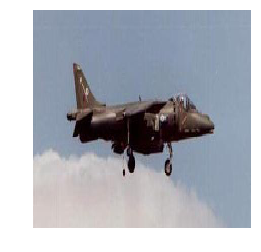

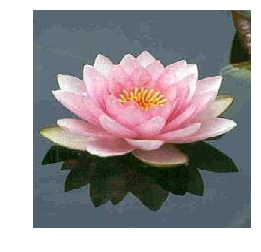

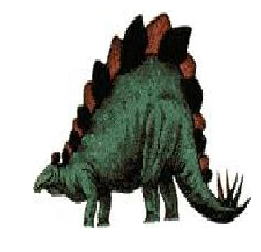

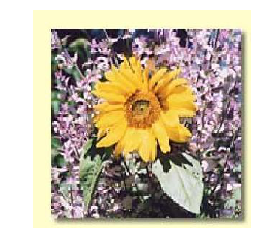

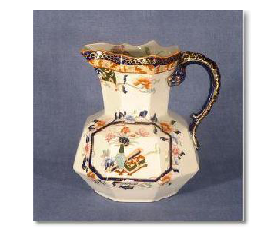

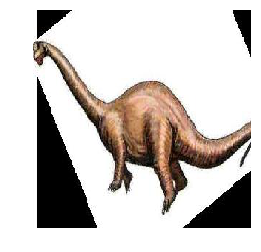

In [14]:
# Visualize the resulting images
#indices = [8194, 8551, 5005, 2166, 2140, 2157]
#indices = [8451, 337, 7316, 323, 7375, 7327]
#indices = [1616, 419, 268, 8382, 8383, 8425]

indices = [1616, 419, 5005, 8382, 7375, 2157]

for i in indices:
    show_img(X_paths[i])

***

**b)** Looking at the results, what can you say about the "types" of images that obtain good retrieval scores compared to those obtaining poor retrieval scores? Give an explanation and possible solution(s).

(*HINT: How did we obtain data representations for similarity measures?*)

**Answer:**

First of all, we know that the resolution of the images used here is small: 224x224. This means that during analysis of the network, only the bigger features were visible to be analysed. This means that the CNN has only been able to analyze the features that were still visible, which means those with high contrast and sharp edges. This can also be seen in the resulting images printed above. The result with 0 correct neigbors is the plane. Due to low resolution, there are not many edges that indicate this image to be a plane. Most edges to denote the wings and other properties have vanished, and the outline is the most prominent feature visible here. 

In addition, the angle of the image is also not typical for a plane. Normally, one would clearly see wings, and maybe a large number of planes was photographed on the ground. The fact that this is not a typical example of the class makes it more likely that the clustering algorithm was not able to position it correctly.

On the other hand, the image with the highest number of correctly retrieved neigbors is a typical drawing of a dinosaur. The view from the side shows features that are very characteristic. In addition, the contrast is high and there are not many small features that disappeared due to low resolution. The form-factor of a dinosaur is very unique as well, and will not easily be confused with other objects. The white background for the two dinosaurs may have helped in their classification too.

Secondly, we know that VGG16 is pretrained on ImageNet, whereas we are using it to classify images from the Caltech101 set. Typically, training and testing data originate from the same corpus. Here, this is not the case, and the resulting scores may have deteriorated due to this. If the training data consists of only birds, it can recognize features belonging to this category, but not features such as a cat's ears or a dog's tail. It then also fails to correctly analyze the plane, as there are no features it recognizes. It will then put it in the same category as other images it cannot classify, and retrieve neighbors with other classes for a plane image. 

Of course, there are other factors that play a role too. One is the amount of images per class contained in the dataset. If this is low, the chances are much higher that the neighbors are of other classes, due to the fact that a higher percentage of neigbors is part of another class. The same holds when an image is an edge case within a class. Its position within a cluster has a high influence on the number of correct neighbors retrieved. 

In general, as a solution to the classification problem, we would suggest training the network on the same type of images that we test them on. In this case, VGG16 should be trained on the Caltech101 database before analyzing whether the retrieval of neighbors is done correctly.
As for a solution to the problem of resolution, we would suggest to start training with bigger images and relatively small filters, to pick up small details as well. As for the fact that some images are not representative of their class at all, there is no easy solution for that. Training with typical images will not necessarily increase recognition of a-typical images. Training on a-typical images may decrease reliability. The answer may lie in adding more neurons to each convolutional layer, to retrieve more features, both typical and a-typical.





***

### Task 1.3: Subjective evaluation
We will now use the "fc2"-features to do image retrieval for query images from the "BACKGROUND_Google" set from the Caltech101 dataset. These images are not associated to a particular class, so we will evaluate them subjectively instead.

**a)** Find two query images from the "BACKGROUND_Google" class, such that for the first query image relevant/similar images are retrieved (according to your own definition of relevancy/similarity), and for the second image mainly irrelevant/dissimilar images are retrieved. For each of them, visualise its 5 nearest neighbors in the Caltech101 dataset (*so do NOT retrieve images from the "BACKGROUND_Google" class!*), according to the "fc2-features" and L2-distance.

In [ ]:
# load the BACKGROUND_Google set
with open(os.path.join("data","caltech101_VGG16_fc2_bg.p"), "rb") as f:
    bg_fc2, bg_paths = pickle.load(f)


# === SOLUTION: ===
# insert code here

***

**b)** Motivate your idea of "relevance": why do you consider the results for the first image relevant/similar, and those for the second image irrelevant/dissimilar?

**Answer:**

*=== write your answer here ===*

***

**c)** Explain why you think this retrieval method (nearest neighbor for neural codes from VGG16) performs better on the first image than on the second.

**Answer:**

*=== write your answer here ===*

***

### Task 1.4: Dimensionality reduction

**a)** So far we've been using 4096-dimensional neural codes. This space is however still quite high-dimensional. Apply a dimensionality reduction method and evaluate the effect on the retrieval performance.

* Use PCA to obtain lower-dimensional representations of the Caltech101 data "fc2"-features (try the same compression rates as in Table 2 of the "Neural Codes for Image Retrieval" paper).
* Evaluate the same retrieval task as explained at the start of this question for each of the compression rates/dimensionalities. Report the retrieval scores.

*HINT: See http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html on how to transform a dataset with PCA.*

In [ ]:
# import PCA from scikit-learn
from sklearn.decomposition import PCA

In [ ]:
# load the data
datapath = "caltech101_VGG16_fc2.p"
with open(os.path.join("data", datapath), "rb") as f:
    X_fc, y, X_paths, classes = pickle.load(f)
    
# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 8677  # the dataset has 8677 images
indices = np.random.choice(range(n_examples), size=n, replace=False)


# === SOLUTION: ===
# insert code here

***

**b)** Discuss your results: how much can you further reduce the dimensionality of the data representations, without affecting the retrieval performance (much)? Compare these results to those from the paper, are your conclusions similar or not?

**Answer:**

*=== write your answer here ===*

***

## Question 2: Fashion-MNIST (12.5pt)
For this question we will work with the "Fashion-MNIST" dataset. This dataset is modelled to have the same specifics as MNIST; it consists of a training set of 60,000 examples, and a test set of 10,000 examples. Each example is a 28x28 greyscale image, associated with a label from one of 10 classes. The images represent various clothing items (as opposed to handwritten digits for MNIST), each class represents a different type of clothing item. The following classes exist:
* 0:	T-shirt/top
* 1:	Trouser
* 2:	Pullover
* 3:	Dress
* 4:	Coat
* 5:	Sandal
* 6:	Shirt
* 7:	Sneaker
* 8:	Bag
* 9:	Ankle boot

In this question we will investigate various ways to model visual similarity for this dataset, in order to perform image retrieval. For more info about the dataset, see https://github.com/zalandoresearch/fashion-mnist.

The dataset can directly be obtained through Keras:

In [ ]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras import backend as K

# load the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# properties of the data
img_rows, img_cols, chns = 28, 28, 1
n_classes = 10

# reshape
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], chns, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], chns, img_rows, img_cols)
    input_shape = (chns, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
    input_shape = (img_rows, img_cols, chns)

# normalise
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

# transform labels to one-hot encoding, but also keep original single-digit encoding
y_train_digits = y_train
y_test_digits = y_test
y_train = to_categorical(y_train_digits, n_classes)
y_test = to_categorical(y_test_digits, n_classes)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# show an example
example_id = 0  # pick any integer from 0 to 59999 to visualize a training example
example = x_train[example_id].reshape(img_rows, img_cols)
label = y_train[example_id]
label_digit = y_train_digits[example_id]
label_class = classes[label_digit]
plt.matshow(example, cmap="gray")
plt.axis("off")
plt.show()
print("Class: {} ({})".format(label_class, label_digit))

Consider the following situation: We have a fully labelled dataset (the ***labelled set***) of the images from the first 5 classes (t-shirts/tops, trousers, pullovers, dresses, coats). We are then supplied with an unlabelled dataset (the ***retrieval set***) containing the remaining Fashion-MNIST images (sandals, shirts, sneakers, bags, ankle boots) on which we want to be able to perform image retrieval. So we cannot use labels from the retrieval set, since we do not know them (note that in our case we *do* have the labels, but we will only use them for evaluation).

The following code splits the dataset up into two sets representing 5 classes each. Observe that the labelled and the retrieval set have exactly the same size.

In [ ]:
# obtain indices of labelled and retrieval sets
indices_train_l = np.argwhere(y_train_digits < 5).flatten()  # indices labelled training set
indices_train_r = np.argwhere(y_train_digits >= 5).flatten()  # indices retrieval training set
indices_test_l = np.argwhere(y_test_digits < 5).flatten()  # indices labelled test set
indices_test_r = np.argwhere(y_test_digits >= 5).flatten()  # indices retrieval test set

# split up train and test set (images and labels)
x_train_l = x_train[indices_train_l]
x_train_r = x_train[indices_train_r]
y_train_l = y_train[indices_train_l]
y_train_r = y_train[indices_train_r]
y_train_digits_l = y_train_digits[indices_train_l]
y_train_digits_r = y_train_digits[indices_train_r]
x_test_l = x_test[indices_test_l]
x_test_r = x_test[indices_test_r]
y_test_l = y_test[indices_test_l]
y_test_r = y_test[indices_test_r]
y_test_digits_l = y_test_digits[indices_test_l]
y_test_digits_r = y_test_digits[indices_test_r]

# labels are now one-hot encoded 10-dimensional vectors, but only the first or last five dimensions are used
# omit unused dimensions to obtain 5-dimensional one-hot encodings
y_train_l = y_train_l[:, :5]
y_train_r = y_train_r[:, 5:]
y_test_l = y_test_l[:, :5]
y_test_r = y_test_r[:, 5:]
# (note that the dimensions of y_train_l/y_test_l do not correspond to those of y_train_r/y_test_r now)

# print the shapes
print(x_train_l.shape)
print(x_train_r.shape)
print(y_train_l.shape)
print(y_train_r.shape)
print(y_train_digits_l.shape)
print(y_train_digits_r.shape)
print(x_test_l.shape)
print(x_test_r.shape)
print(y_test_l.shape)
print(y_test_r.shape)
print(y_test_digits_l.shape)
print(y_test_digits_r.shape)

***

### Task 2.1: Fashion neural retrieval
**a)** Design an MLP (multilayer perceptron) for classification on the first 5 classes of the Fashion-MNIST dataset (i.e. only use `x_train_l` for training). You may include Dropout and BatchNormalization if needed. Let the last hidden dense layer (before the 5-dimensional output layer) have 128 dimensions. (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later.*)

Train it to classify images into their corresponding classes. Make sure that it achieves decent accuracy (at least 90%) on the labelled test set `x_test_l` (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [ ]:
# import sequential model and layers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization

In [ ]:
mlp = Sequential()

# === SOLUTION: ===
# insert code here

In [ ]:
# create directory if doesn't exist yet
try:
    os.mkdir("assignment2_models")
except(FileExistsError):
    pass

# save the model
mlp.save(os.path.join("assignment2_models", "mlp_fashionmnist_l.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

*=== write your answer here ===*

***

### Task 2.2: Fashion neural retrieval #2
**a)** Design a CNN (convolutional neural network) for classification on the first 5 classes of the Fashion-MNIST dataset (i.e. only use x_train_l for training), consisting of a number of Convolutions with Max-Pooling, followed by one or more Dense layers. You may use Dropout and BatchNormalization to improve generalization and training speed. Let the last hidden dense layer (before the 5-dimensional output layer) have 128 dimensions. (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later.*)

Train the CNN to classify images into their corresponding classes. Make sure that it achieves decent accuracy (at least 94%) on the test set `x_test_l` (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [ ]:
# import additional layers
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
cnn = Sequential()

# === SOLUTION: ===
# insert code here

In [ ]:
# save the model
cnn.save(os.path.join("assignment2_models", "cnn_fashionmnist_l.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

*=== write your answer here ===*

***

### Task 2.3: Fashion neural retrieval #3
**a)** Design a (convolutional) Denoising Autoencoder (DAE) for the *full* Fashion-MNIST dataset (i.e. use `x_train`, *not* `x_train_l`). For the encoder, use only Convolutional layers and Max-Pooling, followed by a Dense layer with 128 units. The output of this layer will be the "code" of the autoencoder (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later*). For the decoder, start with a Dense layer to upscale to a suitable dimension, and then use only Convolutional layers and UpSampling. You may use BatchNormalization to speed up training.

Train the DAE to reconstruct noisy images to the original input images. Make sure that it achieves a binary cross-entropy loss of at most 0.29 on the test set (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [ ]:
# import additional layer
from keras.layers import UpSampling2D, Reshape

In [ ]:
# obtain noisy version of data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


# define autoencoder
dae = Sequential()

# === SOLUTION: ===
# insert code here

In [ ]:
# save the model
dae.save(os.path.join("assignment2_models", "dae_fashionmnist.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

*=== write your answer here ===*

***

Visualise a few test examples, their noisy versions, and their reconstructions.

In [ ]:
# NOTE: you don't need to change this code, just run it after having trained the DAE
def plot_examples(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

x_test_reconstr = dae.predict(x_test_noisy, batch_size=batch_size)

plot_examples(x_test)
plot_examples(x_test_noisy)
plot_examples(x_test_reconstr)

**c)** Do you consider the results acceptable? Do you think they can be useful for image retrieval? Explain why in one or two sentences.

**Answer:**

*=== write your answer here ===*

***

**d)** Why can we train on the full dataset `x_train` here, whereas in Tasks 2.1 and 2.2 we had to use `x_train_l` (the first 5 classes only) for training?

**Answer:**

*=== write your answer here ===*

***

### Task 2.4: Fashion neural retrieval #4
Autoencoders come in different shapes and sizes. One key defining property of autoencoders is the means the model uses to prevent the learning of the identity function. Typically, this is done with different regularization methods. In the previous task you used a model that uses noise as a regularizer. In this task you will develop a Sparse Autoencoder (SAE). A sparse autoencoder uses a sparsity regularization to obtain sparse representations of the input data. Sparsity can be achieved by using L1-regularization on the activations of the hidden "code" layer.

**a)** Design a (convolutional) Sparse Autoencoder (SAE) for the *full* Fashion-MNIST dataset (i.e. use `x_train`, *not* `x_train_l`). For the encoder, use only Convolutional layers and Max-Pooling, followed by a Dense layer with 128 units. The output of this layer will be the "code" of the autoencoder (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later*). Add an activity regularizer to this layer, using `regularizers.l1(10e-5)` from Keras.
For the decoder, start with a Dense layer to upscale to a suitable dimension, and then use only Convolutional layers and UpSampling. You may use BatchNormalization to speed up training.

Train the SAE to reconstruct input images. Make sure that it achieves a loss value of at most 0.31 on the test set (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [ ]:
# import regularizers for sparse autoencoder
from keras import regularizers

In [ ]:
# define autoencoder
sae = Sequential()

# === SOLUTION: ===
# insert code here

In [ ]:
# save the model
sae.save(os.path.join("assignment2_models", "sae_fashionmnist.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

*=== write your answer here ===*

***

Visualise a few test examples and their reconstructions.

In [ ]:
# NOTE: you don't need to change this code, just run it after having trained the SAE
def plot_examples(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

x_test_reconstr = sae.predict(x_test, batch_size=batch_size)

plot_examples(x_test)
plot_examples(x_test_reconstr)

**c)** Compare the visual results to those of the DAE in Task 2.3. Also compare the loss values of the test set for the DAE and SAE. How can you explain the difference?

**Answer:**

*=== write your answer here ===*

***

### Task 2.5: Comparison
Obtain 128-dimensional neural code representations of the last five classes of the Fashion-MNIST dataset (the *retrieval set*: `x_train_r`) from the following models/layers:
1. The last dense hidden layer (before the output layer) of the MLP you trained in Task 2.1
2. The last dense hidden layer (before the output layer) of the CNN you trained in Task 2.2
3. The center layer/code of the DAE you trained in Task 2.3
4. The center layer/code of the SAE you trained in Task 2.4
5. A PCA-transformation

In [ ]:
# additional imports
from keras.models import load_model
from keras.models import Model

In [ ]:
# load the previously trained and saved models
mlp = load_model(os.path.join("assignment2_models", "mlp_fashionmnist_l.h5"))
cnn = load_model(os.path.join("assignment2_models", "cnn_fashionmnist_l.h5"))
dae = load_model(os.path.join("assignment2_models", "dae_fashionmnist.h5"))
sae = load_model(os.path.join("assignment2_models", "sae_fashionmnist.h5"))
    
# NOTE: change the name "neural codes" if the layer from which you wish to retrieve neural codes has a different name
mlp_nc = Model(inputs=mlp.input, outputs=mlp.get_layer("neural_codes").output)
cnn_nc = Model(inputs=cnn.input, outputs=cnn.get_layer("neural_codes").output)
dae_nc = Model(inputs=dae.input, outputs=dae.get_layer("neural_codes").output)
sae_nc = Model(inputs=sae.input, outputs=sae.get_layer("neural_codes").output)

# obtain flat representations of the data
x_train_r_flat = x_train_r.reshape((x_train_r.shape[0], -1))
x_test_r_flat = x_test_r.reshape((x_test_r.shape[0], -1))

# train PCA on the retrieval set
pca = PCA(n_components=128)
pca.fit(x_train_r_flat)

# obtain 128-dimensional representations
nc_mlp_train = mlp_nc.predict(x_train_r)
nc_mlp_test = mlp_nc.predict(x_test_r)
nc_cnn_train = cnn_nc.predict(x_train_r)
nc_cnn_test = cnn_nc.predict(x_test_r)
nc_dae_train = dae_nc.predict(x_train_r)
nc_dae_test = dae_nc.predict(x_test_r)
nc_sae_train = sae_nc.predict(x_train_r)
nc_sae_test = sae_nc.predict(x_test_r)
nc_pca_train = pca.transform(x_train_r_flat)
nc_pca_test = pca.transform(x_test_r_flat)

# print the shapes to confirm all features are 128-dimensional
print(nc_mlp_train.shape)
print(nc_mlp_test.shape)
print(nc_cnn_train.shape)
print(nc_cnn_test.shape)
print(nc_dae_train.shape)
print(nc_dae_test.shape)
print(nc_sae_train.shape)
print(nc_sae_test.shape)
print(nc_pca_train.shape)
print(nc_pca_test.shape)

***

**a)** Evaluate the retrieval task as described in Question 1 on the last 5 classes (the retrieval set) of the Fashion-MNIST dataset, for the five data representations given above. Use query images from the test set and retrieve images from the training set only. Print the five resulting retrieval scores (between 0 and 5).

*HINT: you can use* `y_train_digits_r` *and* `y_test_digits_r` *to obtain digit encodings (as opposed to one-hot encodings) of the data labels.*

In [ ]:
# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 5000  # the retrieval test set has 5000 images
indices = np.random.choice(range(n_examples), size=n, replace=False)

representations = [
    (nc_mlp_train, nc_mlp_test),
    (nc_cnn_train, nc_cnn_test),
    (nc_dae_train, nc_dae_test),
    (nc_sae_train, nc_sae_test),
    (nc_pca_train, nc_pca_test),
]
for (nc_train, nc_test) in representations:
    # === SOLUTION: ===
    # insert code here

***

**b)** Compare the "baseline" PCA-transformed data with the other methods. Is PCA a suitable method to obtain representations for image retrieval in this situation? Why do you think so? Would you expect a similar conclusion for the Caltech101 dataset from Question 1?

**Answer:**

*=== write your answer here ===*

***

Observe the difference between encodings from the DAE and SAE.

In [ ]:
print("Mean activation for DAE encodings:", np.mean(nc_dae_train))
print("Mean activation for SAE encodings:", np.mean(nc_sae_train))

index = 1  # try a few indices here
print("DAE encoding example:")
print(nc_dae_train[index])
print("SAE encoding example:")
print(nc_sae_train[index])

**c)** Discuss the difference in encodings between the two autoencoders (denoising and sparse). Also discuss the difference in retrieval performance for these encodings. How would you explain this difference?

**Answer:**

*=== write your answer here ===*

***

**d)** What is the best performing method you found in part a)? Describe what advantage you believe this method has over the others.

**Answer:**

*=== write your answer here ===*